In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simpson
from ed import *
from dos import *
import warnings
warnings.filterwarnings("ignore")

# Computing non-interacting Green's function for semicircle density of state

In [4]:
def get_G0_semicirc(omFs, mu, t):
    '''
    Computing non-interacting Green's function for semicricle density of state.
    Inputs: omFs: numpy.array: real frequency
            mu:   float: checmical potential
            t :   float: hopping amplitude of the Bethe lattice
    Outputs: G0:  numpy.array: Green's function on real frequency
    '''
    from dos import semicircle
    from scipy.integrate import simpson
    ws = np.linspace(-2*t,2*t,1000)
    sc_dos = semicircle(ws,t)
    G0 = np.zeros(len(omFs),dtype=complex)
    for iomF, omF in enumerate(omFs):
        y = sc_dos/(1j*omF+mu-ws)
        G0[iomF] = simpson(y, ws)
    return G0

In [5]:
def get_G0_aim(omFs, V, eb, ed, mu):
    G0_aim = np.zeros(len(omFs),dtype=complex)
    for iomF, omF in enumerate(omFs):
        Delta = 0.0
        for ib in range(eb.shape[0]):
            Delta += (V[ib]*np.conj(V[ib])).real/(1j*omF-eb[ib])
        G0_aim[iomF] = 1./(1j*omF - ed + mu - Delta)
    return G0_aim

def get_G0w_aim(ws, eta, V, eb, ed, mu):
    G0_aim = np.zeros((len(ws)),dtype=complex)
    for iw, w in enumerate(ws):
        Delta = 0.0
        for ib in range(eb.shape[0]):
            Delta += (V[ib]*np.conj(V[ib])).real/(w + 1j*eta - eb[ib])
        G0_aim[iw] = (1./(w + 1j*eta - ed + mu - Delta))[0]
    return G0_aim

In [6]:
def cost_func(x, *args):
    omFs, ed, mu, G0, Nb, Nmax = args
    V = x[:Nb] + 1j*x[Nb:2*Nb]
    eb = x[2*Nb:3*Nb]
    G0_aim = get_G0_aim(omFs, V, eb, ed ,mu)
    cost = 0.0
    for iomF in range(Nmax):
        diff = 1./G0_aim[iomF] - 1./G0[iomF]
        cost += (np.conj(diff)*diff).real/omFs[iomF]**1
    return cost 

In [7]:
np.random.seed(1234)
np.set_printoptions(suppress=True, precision=8)

# initial density of state
T = 0.005
t = 0.5
mu = 0.0
Nb = 3
Nmax = 100
mix = 0.5
maxit = 500

NomF = Nmax
omFs = (2*np.arange(NomF)+1)*np.pi*T

G0 = get_G0_semicirc(omFs, mu, t)

no = 2*(1+Nb)
print('no=',no)
FH_list = build_fermion_op(no)
print(len(FH_list))
FH_list_dense = [np.array(FH.todense(),dtype=complex) for FH in FH_list]

ebs = np.random.uniform(-1,1,Nb)
Vrs = np.random.uniform(-0.5,0.5,Nb)
Vis = np.zeros((Nb))
x0 = np.hstack((Vrs,Vis,ebs))
  
U = 1.5

it = 0
diff = 1e20
while diff > 5e-5 and it<maxit:
    print("-------------------------------------- it=%d U=%.2f --------------------------------------"%(it, U))

    # fit V eb
    args = omFs, 0.0, mu, G0, Nb, Nmax
    result = minimize(cost_func,x0,args=args, method='L-BFGS-B', options={'gtol': 1e-2, 'eps': 1e-12})
    print("GA root convergence message---------------------------------")
    print("sucess=",result.success)
    print(result.message)
    V = result.x[:Nb] + 1j*result.x[Nb:2*Nb]
    eb = result.x[2*Nb:3*Nb]
    x0 = result.x
    print('V=',V)
    print('eb=', eb)
    
    # ED part
    h1 = np.array([[-U/2+mu, 0.0],
                   [ 0.0,-U/2+mu]])
    eb = np.kron(eb,np.ones((2)))
    V = np.kron(V,np.eye(2)).T
    
    V2E = np.zeros((2,2,2,2))
    V2E[1,1,0,0] = U
    V2E[0,0,1,1] = U
    print('V(ED)=',V)
    print('eb(ED)=', eb)

    dm, evals, evecs, docc = solve_Hemb_thermal(T, h1, V, eb, V2E, FH_list, verbose=0)
        
    print('dm=')
    print(dm.real)
    print('trace(dm)=',np.trace(dm).real)
    print('docc=', docc.real)
    
    GomF = compute_GomF_thermal(T, omFs, evals, evecs, FH_list_dense)
    
    # update G0
    G0_new = 1./(1j*omFs + mu - t**2*GomF)

    diff = np.sum(np.abs(G0_new  -G0))
    print('diff=', diff)
    it += 1
    G0 = (1-mix)*G0 + mix*G0_new

# real frequency quantities
ws = np.linspace(-5,5,200) # frequency mesh
eta = 0.1 #broadening factor
Gw = compute_Gw_thermal(T, ws, eta, evals, evecs, FH_list_dense) # real frequency impurity Green's function
G0w = get_G0w_aim(ws, eta, V[::2,::2], eb[::2], 0.0, mu) # real frequency non-interacting impurity Green's function
Sigw = 1./G0w - 1./Gw # real frequency self-energy
Glattw = compute_Glattw_semcircle(ws,eta,Sigw,mu) # real frequency lattice Green's function
# Matsubara self-energy
G0 = get_G0_aim(omFs, V[::2,::2], eb[::2], 0.0, mu) # matsubara frequency impurity Green's function
Sig = 1./G0 - 1./GomF # Matsubara frequency self-energy
Z = 1./(1-(Sig[0].imag)/(omFs[0])) # quasiparticle weight estimate from Matsubara self-energy
Glatt = compute_GlattomF_semcircle(omFs,Sig,mu) # real frequency lattice Green's function

np.savetxt('Gimpw_U%.2f.dat'%(U),np.vstack((ws,Gw.real,Gw.imag)).T)
np.savetxt('Glattw_U%.2f.dat'%(U),np.vstack((ws,Glattw.real,Glattw.imag)).T)
np.savetxt('Gimp_U%.2f.dat'%(U), np.vstack((omFs,GomF.real,GomF.imag)).T)
np.savetxt('Glatt_U%.2f.dat'%(U), np.vstack((omFs,Glatt.real,Glatt.imag)).T)
np.savetxt('G0_U%.2f.dat'%(U), np.vstack((omFs,G0.real,G0.imag)).T)
np.savetxt('Sig_U%.2f.dat'%(U), np.vstack((omFs,Sig.real,Sig.imag)).T)
np.savetxt('Sigw_U%.2f.dat'%(U), np.vstack((ws,Sigw.real,Sigw.imag)).T)
np.savetxt('x0_U%.2f.dat'%(U), x0)

print(U, dm[0,0].real, dm[1,1].real, docc.real, Z, diff)

no= 8
8
-------------------------------------- it=0 U=1.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
V= [ 0.26451211+0.j  0.26451413+0.j -0.07980677+0.j]
eb= [-0.15225325  0.15225749  0.00000006]
V(ED)= [[ 0.26451211+0.j  0.        +0.j]
 [ 0.        +0.j  0.26451211+0.j]
 [ 0.26451413+0.j  0.        +0.j]
 [ 0.        +0.j  0.26451413+0.j]
 [-0.07980677+0.j -0.        +0.j]
 [-0.        +0.j -0.07980677+0.j]]
eb(ED)= [-0.15225325 -0.15225325  0.15225749  0.15225749  0.00000006  0.00000006]
Egs= -1.352066825500095
evals= [0.         0.02789563 0.02789563 0.02789654 0.02789654 0.04938199
 0.04938199 0.04938199 0.06528966 0.06529093]
dm=
[[ 0.5000001  -0.         -0.25441862  0.         -0.25441672 -0.
   0.23807431  0.        ]
 [-0.          0.5000001   0.         -0.25441862  0.         -0.25441672
   0.          0.23807431]
 [-0.25441862  0.          0.79439475  0.  

Egs= -1.2224883416921455
evals= [0.         0.02545916 0.02545916 0.02546191 0.02546191 0.04540044
 0.04540044 0.04540044 0.05876843 0.05877135]
dm=
[[ 0.50000085  0.         -0.24036631  0.         -0.24037735 -0.
   0.23342398  0.        ]
 [ 0.          0.50000085  0.         -0.24036631 -0.         -0.24037735
  -0.          0.23342398]
 [-0.24036631  0.          0.80396671  0.         -0.0000006  -0.
   0.2737452   0.        ]
 [ 0.         -0.24036631  0.          0.80396671 -0.         -0.0000006
  -0.          0.2737452 ]
 [-0.24037735 -0.         -0.0000006  -0.          0.19604617  0.
  -0.27374532 -0.        ]
 [-0.         -0.24037735 -0.         -0.0000006   0.          0.19604617
   0.         -0.27374532]
 [ 0.23342398 -0.          0.2737452  -0.         -0.27374532  0.
   0.49998957  0.        ]
 [ 0.          0.23342398  0.          0.2737452  -0.         -0.27374532
   0.          0.49998957]]
trace(dm)= 4.0000066117728865
docc= 0.11260031715495754
diff= 0.06536623916

dm=
[[ 0.50000062  0.         -0.24017097  0.         -0.24016429 -0.
   0.23341583  0.        ]
 [ 0.          0.50000062  0.         -0.24017097 -0.         -0.24016429
   0.          0.23341583]
 [-0.24017097  0.          0.80413884  0.          0.00001508 -0.
   0.27363626  0.        ]
 [ 0.         -0.24017097  0.          0.80413884 -0.          0.00001508
   0.          0.27363626]
 [-0.24016429 -0.          0.00001508 -0.          0.19583627  0.
  -0.27362115 -0.        ]
 [-0.         -0.24016429 -0.          0.00001508  0.          0.19583627
  -0.         -0.27362115]
 [ 0.23341583  0.          0.27363626  0.         -0.27362115 -0.
   0.50001794  0.        ]
 [ 0.          0.23341583  0.          0.27363626 -0.         -0.27362115
   0.          0.50001794]]
trace(dm)= 3.9999873512299176
docc= 0.11242107994879477
diff= 0.0022179892112571455
-------------------------------------- it=11 U=1.50 --------------------------------------
GA root convergence message-----------------

diff= 7.267692094143874e-05
-------------------------------------- it=16 U=1.50 --------------------------------------
GA root convergence message---------------------------------
sucess= True
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
V= [ 0.21954771+0.j  0.21955626+0.j -0.07748518+0.j]
eb= [-0.11926937  0.11928736  0.00000102]
V(ED)= [[ 0.21954771+0.j  0.        +0.j]
 [ 0.        +0.j  0.21954771+0.j]
 [ 0.21955626+0.j  0.        +0.j]
 [ 0.        +0.j  0.21955626+0.j]
 [-0.07748518+0.j -0.        +0.j]
 [-0.        +0.j -0.07748518+0.j]]
eb(ED)= [-0.11926937 -0.11926937  0.11928736  0.11928736  0.00000102  0.00000102]
Egs= -1.2212728569827456
evals= [0.         0.02544386 0.02544386 0.02544911 0.02544911 0.0453749
 0.0453749  0.0453749  0.05873165 0.05873831]
dm=
[[ 0.50000058 -0.         -0.24016988  0.         -0.24016274 -0.
   0.233417    0.        ]
 [-0.          0.50000058 -0.         -0.24016988  0.         -0.24016274
  -0.          0.233417  ]
 [-0.24016988 -0.    

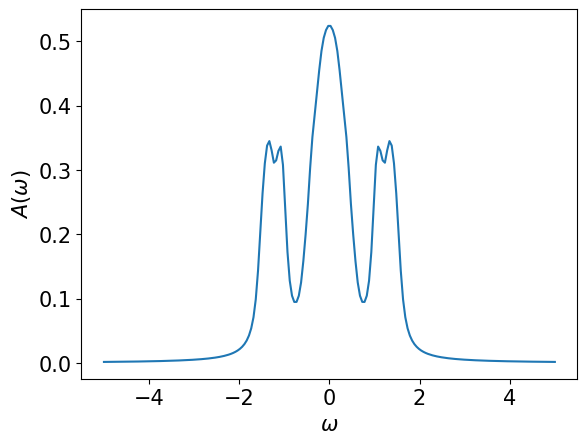

spectral weight= 0.9868150140870853


In [8]:
data = np.loadtxt('Glattw_U1.50.dat').T

plt.plot(data[0],-data[2]/np.pi)
plt.xlabel('$\omega$',size=15)
plt.ylabel('$A(\omega)$',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()
print('spectral weight=', simpson(-data[2]/np.pi, data[0]))

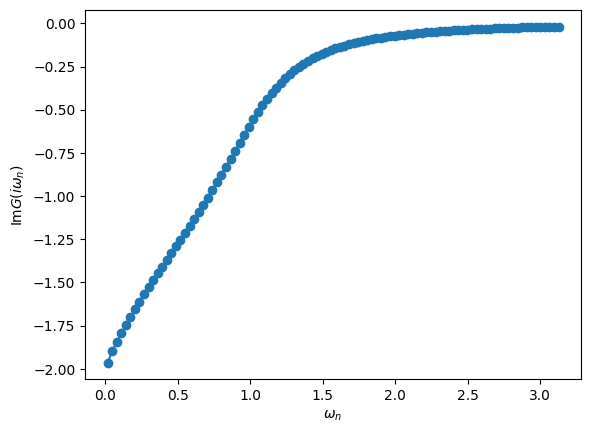

In [17]:
data = np.loadtxt('Glatt_U1.50.dat').T

plt.plot(data[0],data[2],'-o')
plt.xlabel('$\omega_n$')
plt.ylabel('Im$G(i\omega_n)$')
plt.show()

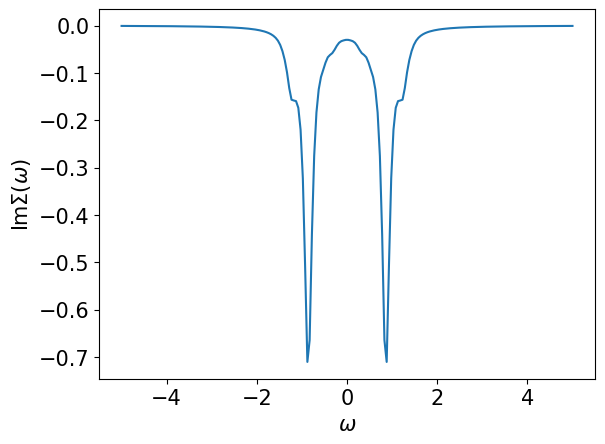

In [10]:
data = np.loadtxt('Sigw_U1.50.dat').T

plt.plot(data[0],data[2]/np.pi,'-')
plt.xlabel('$\omega$',size=15)
plt.ylabel('Im$\Sigma(\omega)$',size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

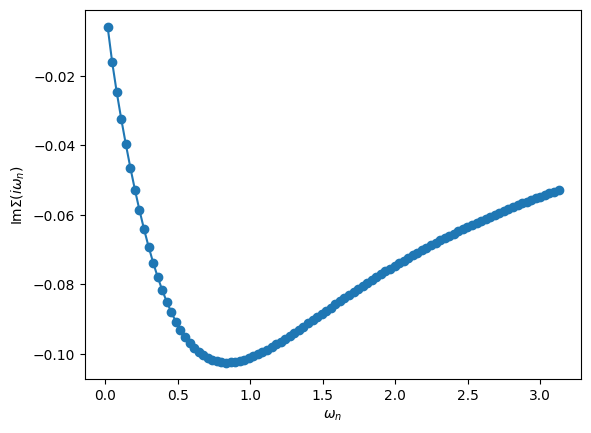

In [19]:
data = np.loadtxt('Sig_U1.50.dat').T

plt.plot(data[0],data[2]/np.pi,'-o')
plt.xlabel('$\omega_n$')
plt.ylabel('Im$\Sigma(i\omega_n)$')
plt.show()